# In this Notebook we are attempting to predict a persons next N fights

## Library Imports

In [3]:
import sys
sys.path.insert(1, '../helpers')
from make_career import make_career

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Model imports
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LSTM, Input
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid

# Helpers and plot

In [12]:
# Extract numerical and categorical columns
def get_column_types():
    num_cols = []
    cat_cols = []
    for fight in features[0][0]:
        feature_type = type(features[1][1][fight])
        if feature_type is not float and feature_type is not int:
            cat_cols.append(fight)
        else:
            num_cols.append(fight)
            
    return num_cols, cat_cols


def plot_training_results():
    acc_1 = history.history['Fight_1_accuracy']
    acc_2 = history.history['Fight_2_accuracy']
    acc_3 = history.history['Fight_3_accuracy']
    acc_4 = history.history['Fight_4_accuracy']
    acc_5 = history.history['Fight_5_accuracy']
    
    val_acc_1 = history.history['val_Fight_1_accuracy']
    val_acc_2 = history.history['val_Fight_2_accuracy']
    val_acc_3 = history.history['val_Fight_3_accuracy']
    val_acc_4 = history.history['val_Fight_4_accuracy']
    val_acc_5 = history.history['val_Fight_5_accuracy']
    
    epochs = range(1, len(acc_1) + 1)

    fig, (accuracy_axis, training_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc_1, 'b', label='Fight 1 Acc')
    accuracy_axis.plot(epochs, acc_2, 'g', label='Fight 2 Acc')
    accuracy_axis.plot(epochs, acc_3, 'r', label='Fight 3 Acc')
    accuracy_axis.plot(epochs, acc_4, 'c', label='Fight 4 Acc')
    accuracy_axis.plot(epochs, acc_5, 'm', label='Fight 5 Acc')
    accuracy_axis.set_title('Training Set Accuracy over time')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()
    
    training_axis.plot(epochs, val_acc_1, 'b', label='Fight 1 Acc')
    training_axis.plot(epochs, val_acc_2, 'g', label='Fight 2 Acc')
    training_axis.plot(epochs, val_acc_3, 'r', label='Fight 3 Acc')
    training_axis.plot(epochs, val_acc_4, 'c', label='Fight 4 Acc')
    training_axis.plot(epochs, val_acc_5, 'm', label='Fight 5 Acc')
    training_axis.set_title('Test Set Accuracy over time')
    training_axis.set_ylabel('Accuracy')
    training_axis.set_xlabel('Epoch')
    training_axis.legend()
    fig.show()


def encode_all_labels():
    encoded_labels = []
    for row in labels:
        new_labels_list = []
        for elem in row:
            if elem:
                new_labels_list.append(1)
            else:
                new_labels_list.append(0)
        encoded_labels.append(new_labels_list)
    encoded_labels = np.array(encoded_labels)
    
    return encoded_labels


def convert_labels(y_train):  
    fights_1 = np.array(y_train[:,0])
    fights_2 = np.array(y_train[:,1])
    fights_3 = np.array(y_train[:,2])
    fights_4 = np.array(y_train[:,3])
    fights_5 = np.array(y_train[:,4])
    
    y_train = [fights_1, fights_2, fights_3, fights_4, fights_5]
    
    return y_train

# Model Builders - Bottom is CNN, Top is 5 DNNs

In [5]:
def get_ensemble():
    # x_train, y_train, x_val, y_val, params, test_model=False
    fight_input = Input(shape=(10, 97), name='Input')
    x = Conv1D(filters=128, kernel_size=2, activation='relu', name='Conv_1D')(fight_input)
    x = Dropout(0.01, name='Dropout')(x)
    x = Flatten(name='Flatten')(x)

    # Global Dense Network
    x = Dense(128, activation='relu', name='Global_Dense')(x)

    # 5 output layers
    fight_1 = Dense(1, activation='sigmoid', name='Fight_1')(x)
    fight_2 = Dense(1, activation='sigmoid', name='Fight_2')(x)
    fight_3 = Dense(1, activation='sigmoid', name='Fight_3')(x)
    fight_4 = Dense(1, activation='sigmoid', name='Fight_4')(x)
    fight_5 = Dense(1, activation='sigmoid', name='Fight_5')(x)

    model = Model(inputs=fight_input,
                  outputs=[fight_1, fight_2, fight_3, fight_4, fight_5])
    
    model.compile(optimizer='rmsprop',
                 loss={'Fight_1': 'binary_crossentropy', 
                       'Fight_2': 'binary_crossentropy',
                       'Fight_3': 'binary_crossentropy',
                       'Fight_4': 'binary_crossentropy',
                       'Fight_5': 'binary_crossentropy'},
                 loss_weights={'Fight_1': 1., 
                               'Fight_2': 1.,
                               'Fight_3': 1.,
                               'Fight_4': 1.,
                               'Fight_5': 1.},
                 metrics={'Fight_1': 'accuracy', 
                          'Fight_2': 'accuracy',
                          'Fight_3': 'accuracy',
                          'Fight_4': 'accuracy',
                          'Fight_5': 'accuracy'})

    model.summary()
    return model

## Preprocess Features

## Generates np.array of shape (3220, 5 * features)

In [6]:
def collapse_n_fights():
    num_cols, cat_cols = get_column_types()
    
    # Collect only the features we want
    new_features = []
    for window in features:
        window_arr = list(window.reshape(1,-1))[0]
        fight_window = np.array([])
        for fight in window_arr:
            fight_arr = np.array([fight[i] for i in num_cols])
            np.nan_to_num(fight_arr, copy=False)
            fight_window = np.append(fight_window, fight_arr)
        new_features.append(fight_window)
    
    new_features, new_labels = shuffle(np.array(new_features), labels)
    X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, random_state=0, train_size=0.99)
    
    # Scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print('X_train length {}, y_train length {}'.format(X_train.shape, y_train.shape))
    print('X_test length {}, y_test length {}'.format(X_test.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

## Loading the dataset

In [7]:
features, labels = make_career(N_FIGHT_CAREER=10, N_FUTURE_LABELS=5)
labels = encode_all_labels()
print(features.shape, labels.shape)

Creating careers using 10 fight intervals and predicting 5 future fights
Original fight data shape: (5062, 153)
Fights 2x shape: (10124, 95)
Fights after pre-processing: (10124, 100)

Features shape: (600, 10)
Labels shape: (600, 5)

Features is a 2D matrix with 600 rows
Each row contains has 10 fights, and each fight has 100 columns

Labels is a 2D matrix with 600 rows
Each row contains the the prediction for the next 5 fight(s)
(600, 10) (600, 5)


## Building a CNN to predict the winner using last n fights

In [8]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 10, 97)
X_test = X_test.reshape(X_test.shape[0], 10, 97)

print('New: X_train length {}, y_train length {}'.format(X_train.shape, y_train.shape))
print('New: X_test length {}, y_test length {}'.format(X_test.shape, y_test.shape))

y_train = np.array(convert_labels(y_train))
y_test = np.array(convert_labels(y_test))
print(y_train.shape, y_train[0].shape)

X_train length (594, 970), y_train length (594, 5)
X_test length (6, 970), y_test length (6, 5)
New: X_train length (594, 10, 97), y_train length (594, 5)
New: X_test length (6, 10, 97), y_test length (6, 5)
(5, 594) (594,)


In [9]:
model = get_ensemble()
history = model.fit(
    X_train,
    {
        'Fight_1': y_train[0], 
        'Fight_2': y_train[1], 
        'Fight_3': y_train[2], 
        'Fight_4': y_train[3],
        'Fight_5': y_train[4],
    },
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    verbose=1,
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 10, 97)       0                                            
__________________________________________________________________________________________________
Conv_1D (Conv1D)                (None, 9, 128)       24960       Input[0][0]                      
__________________________________________________________________________________________________
Dropout (Dropout)               (None, 9, 128)       0           Conv_1D[0][0]                    
__________________________________________________________________________________________________
Flatten (Flatten)               (None, 1152)         0           Dropout[0][0]                    
____________________________________________________________________________________________

/home/satyaki/env/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


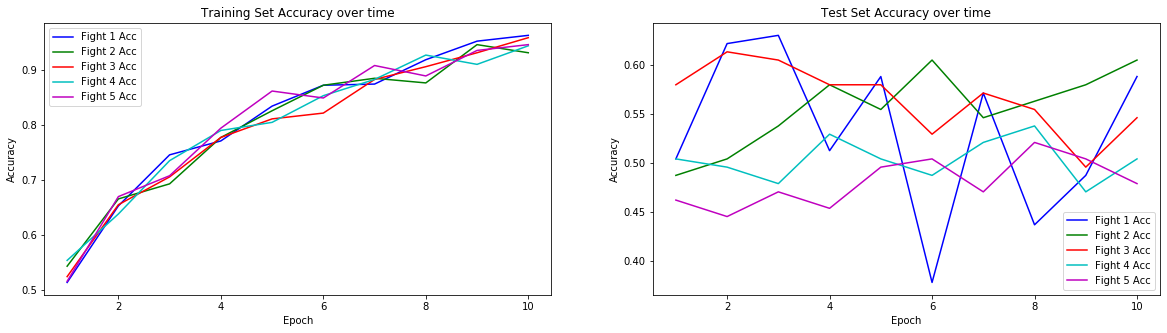

In [13]:
plot_training_results()

In [ ]:
acc = [0.58, 0.60, 0.58]
f1 = [0.69, 0.68, 0.63]
index = ['DNN', '1D CNN', 'LSTM']
df = pd.DataFrame({'Accuracy': acc,
                   'F Score': f1}, index=index)
ax = df.plot.bar(rot=0, figsize=(15,8))
ax.set_ylim(0,1)
ax.set_title('Comparison of several models')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model Type')

In [ ]:
acc = [0.7, 0.72]
f1 = [0.6, 0.81]
index = ['Logistic Regression', 'Dense Neural Network']
df = pd.DataFrame({'Accuracy': acc,
                   'F Score': f1}, index=index)
ax = df.plot.bar(rot=0, figsize=(15,8))
ax.set_ylim(0,1)
ax.set_title('Comparison of DNN vs Logistic Regressor')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model Type')